### Welcome to the [Data-driven Methods for Network-level Coordination of Autonomous Mobility-on-Demand Systems Across Scales](https://rl4amod-itsc24.github.io/) coding tutorial, presented at 27th IEEE ITSC 2024

<img src="figures/gnn-for-amod.png" width="700"/></td> <br/>

Join us in moving the first steps toward the creation of publicly available benchmarks, datasets, and simulators for network-level coordination of MoD systems.

This notebook offers an interactive, hands-on session for benchmarking AMoD controllers across 
- openly accessible simulation platforms across different fidelity levels 
- calibareted scenarios calibrat 
- Implementation of fleet coordination algorithms

### Installation of required packages

In [ ]:
!pip install hydra-core

In [ ]:
!pip install PuLP

In [ ]:
!pip install torch_geometric

In [ ]:
!pip install traci

### Clone the repository

In [ ]:
!git clone https://github.com/StanfordASL/RL4AMOD

In [ ]:
cd RL4AMOD

### 1. The macro environment 

The macro envorinment is based on taxi record data colleted in various city, e.g. New York City, San Francisco, Washignton DC, Shenzhen. In each scenarion, the road network is segmented into stations by clustering junctions such that the travel time within each station is upper-bounded by a given error tolerance. 

In this notebook, we are looking at the nyc brooklyn scenario. It exists of 14 clustered regions with the following demand distribution: 

<img src="figures/demand_profit.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="800"/>


## 2. Baselines

This repository provides a set of baseline policies, that aim to outperform the no-control policy, which serves as the lower bound. 
The simplest of these is the random rebalancing policy. We evaluate its performance against the no-control policy by assessing total profit, calculated as the profit from passengers served minus the cost of rebalancing.

In [13]:
import importlib
import testing
import warnings
warnings.filterwarnings("ignore")
importlib.reload(testing)

<module 'testing' from '/Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD/testing.py'>

In [ ]:
importlib.reload(testing)
config = {
    "simulator.name": "macro",
    "model.name": "random",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
!pwd
testing.test(config)

It’s no surprise that the random rebalancing policy fails to outperform the no-control policy. As shown in the figure on the right, it tends to relocate many vehicles to low-demand regions, resulting in inefficient rebalancing.

### Implement your own controller

The random rebalancing policy is not able to outperform the no control baseline, so let's implement a policy that does. We can develop a control policy that aims to achieve an equal distribution of vehicles across the network while minimizing rebalancing costs.

In [ ]:
from src.misc.utils import dictsum
from src.algos.reb_flow_solver import solveRebFlow
from src.algos.base import BaseAlgorithm


class EqualDistribution(BaseAlgorithm):
    def __init__(self, **kwargs):
        """
        :param cplexpath: Path to the CPLEX solver.
        """
        self.cplexpath = kwargs.get('cplexpath') #None, for no CPLEX

    def select_action(self, env):
        """
        Implements the Equal Distribution (ED) baseline for rebalancing.
        :param env: The current state of the environment
        :return: The rebalancing action to be taken
        """
        # number of regions in this scenario
        nregions = env.nregion
        
        #determines the desired vehicle distirbutions
        action = [1 / nregions for _ in range(nregions)]
        
        #calculates the desired number of vehicles in each region
        desired_acc = {
            env.region[i]: int(action[i] * dictsum(env.acc, env.time +1))
            for i in range(len(env.region))
        }
        
        #calculated the min-cost rebalancing flow to reach desried distirbution
        reb_action = solveRebFlow(env, desired_acc, self.cplexpath) 
        
        return reb_action

Now we can test this new policy and compare it to the no control baseline: 

In [ ]:
config = {
    "simulator.name": "macro",
    "model.name": "equal_distribution",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

While the equal distribution policy significantly boosts profit compared to the no-control baseline, the rebalancing flows still don't align entirely with the demand distribution. (e.g. region 10 and 12)

## 3. RL-based policies 

Although the equal distribution policy already significantly outperforms the no-control baseline, it remains a reactive approach. Instead of relying on a policy that enforces an equal distribution of idle vehicles, we can implement a reinforcement learning (RL) policy that proactively adjusts the distribution based on the current state. 

In this repository, we already provide a pre-trained agent: 

In [ ]:
# from testing import test
config = {
    "simulator.name": "macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_nyc_brooklyn"
}
testing.test(config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Saving sampled demand to saved_files/sample_demand_20250826-143533_supply_factor_1_firm_count_1_dm_portion.json


  0%|          | 0/10 [00:00<?, ?it/s]

Testing model sac on multi_macro environment


Test Episode 10 | Reward: 34589.90 | ServedDemand: 38959.90 | Reb. Cost: 4370.00: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Saved full vehicle distribution to saved_files/vehicle_distribution_20250826-143533_sac_supply_factor_1_firm_count_1_dm_portion.json
Mean Episode Profit ($):  34087.626289213586
Mean Episode Served Demand- Proit($):  38379.626289213586
Mean Episode Rebalancing Cost($):  4292.0
Saving sampled demand to saved_files/sample_demand_20250826-143533_supply_factor_1_firm_count_1_dm_portion.json


  0%|          | 0/10 [00:00<?, ?it/s]

Testing model equal_distribution on multi_macro environment


Test Episode 10 | Reward: 31089.65 | ServedDemand: 35465.65 | Reb. Cost: 4376.00: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Saved full vehicle distribution to saved_files/vehicle_distribution_20250826-143533_equal_distribution_supply_factor_1_firm_count_1_dm_portion.json
Mean Episode Profit ($):  30368.502222481555
Mean Episode Served Demand- Proit($):  34808.502222481555
Mean Episode Rebalancing Cost($):  4440.0
Saving sampled demand to saved_files/sample_demand_20250826-143533_supply_factor_1_firm_count_1_dm_portion.json


  0%|          | 0/10 [00:00<?, ?it/s]

Testing model random on multi_macro environment


Test Episode 10 | Reward: 20500.59 | ServedDemand: 29004.59 | Reb. Cost: 8504.00: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Saved full vehicle distribution to saved_files/vehicle_distribution_20250826-143533_random_supply_factor_1_firm_count_1_dm_portion.json
Mean Episode Profit ($):  23231.67396644108
Mean Episode Served Demand- Proit($):  30735.073966441083
Mean Episode Rebalancing Cost($):  7503.4
No control performance not found. Calculating (this happens only the first time on a new environment)...


Test Episode 10 | Reward: 22621.49 | ServedDemand: 22621.49 | Reb. Cost: 0.00: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


No control performance calculated. Saving in ./src/envs/data/multi_macro/nyc_brooklyn_no_control_performance.json...
/Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD


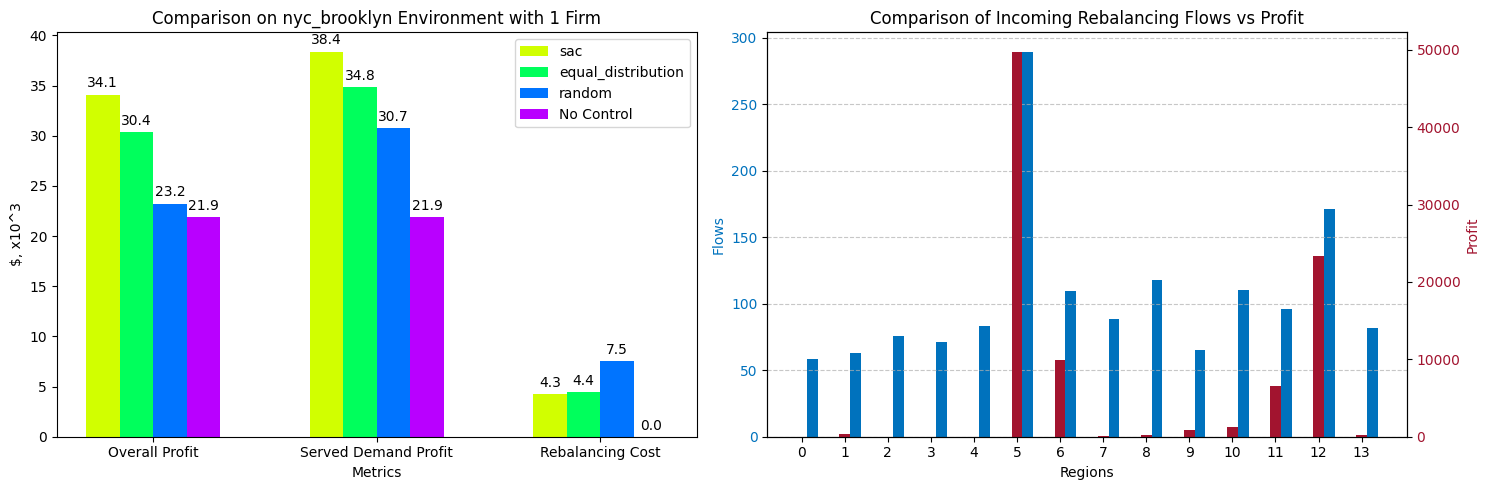

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_nyc_brooklyn",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 1,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True
}
testing.multi_test(config)

In [ ]:
# With not changing x
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": "equal_distribution",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

In [ ]:
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": "random",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.test_episodes": 10,
}
testing.test(config)

### Final comparison

<img src="figures/comparison_final.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="650"/>

## 4. Implement an RL agent

Generally policy takes the current state as input and outputs the next action $\pi(a_t | s_t)$:

<img src="figures/NN_Actor.png" alt="drawing" style="background-color: white; border: 1px solid black;" width="200"/>

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Dirichlet

class Actor(nn.Module):
    """
    Actor \pi(a_t | s_t) parametrizing the concentration parameters of a Dirichlet Policy.
    """

    def __init__(self, in_channels, act_dim, hidden_size=32):
        super().__init__()
        """
        in_channels: state dimension
        act_dim: action dimension
        """
        self.lin1 = nn.Linear(in_channels, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, act_dim)
    
    def forward(self, state):
        x = F.relu(self.lin1(state))
        x = F.relu(self.lin2(x))
        x = F.softplus(self.lin3(x))
    
        concentration = x.squeeze(-1)
        m = Dirichlet(concentration + 1e-20)
        action = m.sample()

        return action

In [ ]:
import torch
import matplotlib.pyplot as plt
'''
The state consits of 14 regions/nodes with 13 node features each
'''
state = torch.ones(14, 13) 

state = state.flatten() #MLP expects a vector input

actor = Actor(in_channels=14*13, act_dim=14)

action = actor(state)

In [ ]:
plt.bar(range(14), action.detach().numpy())
plt.show()

In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Dirichlet
from torch_geometric.nn import GCNConv


class GNNActor(nn.Module):
    """
    Actor \pi(a_t | s_t) parametrizing the concentration parameters of a Dirichlet Policy.
    """

    def __init__(self, in_channels, hidden_size=32, act_dim=6):
        super().__init__()
        self.in_channels = in_channels
        self.act_dim = act_dim
        self.conv1 = GCNConv(in_channels, in_channels)
        self.lin1 = nn.Linear(in_channels, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 1)

    def forward(self, state, edge_index):
        out = F.relu(self.conv1(state, edge_index))
        x = out + state
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.softplus(self.lin3(x))
        
        concentration = x.squeeze(-1)
        m = Dirichlet(concentration + 1e-20)
        action = m.sample()
           
        return action
    

In [ ]:
state = torch.ones(14, 13) 
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13],
                           [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12]])

actor = GNNActor(in_channels=13)

action = actor(state, edge_index)

plt.bar(range(14), action.detach().numpy())
plt.show()

## Train an RL agent

### Portion based / Constant Vehicle Count

In [1]:
import importlib
import testing
import warnings
warnings.filterwarnings("ignore")
importlib.reload(testing)

ImportError: dlopen(/Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD/venv/lib/python3.12/site-packages/torch/_C.cpython-312-darwin.so, 0x0002): Library not loaded: @loader_path/libtorch_cpu.dylib
  Referenced from: <BF62FCCB-56C3-3F10-8807-63842A41DC44> /Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD/venv/lib/python3.12/site-packages/torch/lib/libtorch_python.dylib
  Reason: tried: '/Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD/venv/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/usr/local/lib/libtorch_cpu.dylib' (no such file), '/usr/lib/libtorch_cpu.dylib' (no such file, not in dyld cache)

In [ ]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_portion_2",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
train(config)

In [17]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_portion_1_test_train",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 1,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
train(config)

  0%|          | 0/50 [00:00<?, ?it/s]

Episode 1 | Reward: 2404.10 | ServedDemand: 2404.10 | Reb. Cost: 0.00


Episode 1 | Reward: 32524.87 | ServedDemand: 53752.87 | Reb. Cost: 21228.00:   2%|▏         | 1/50 [00:01<00:59,  1.22s/it]

Episode 1 | Reward: 32524.87 | ServedDemand: 53752.87 | Reb. Cost: 21228.00
Episode 2 | Reward: 3092.50 | ServedDemand: 3092.50 | Reb. Cost: 0.00


Episode 2 | Reward: 35325.60 | ServedDemand: 56323.60 | Reb. Cost: 20998.00:   4%|▍         | 2/50 [00:02<01:00,  1.26s/it]

Episode 2 | Reward: 35325.60 | ServedDemand: 56323.60 | Reb. Cost: 20998.00
Episode 3 | Reward: 3240.90 | ServedDemand: 3240.90 | Reb. Cost: 0.00


Episode 3 | Reward: 41431.69 | ServedDemand: 59385.69 | Reb. Cost: 17954.00:   6%|▌         | 3/50 [00:03<00:57,  1.23s/it]

Episode 3 | Reward: 41431.69 | ServedDemand: 59385.69 | Reb. Cost: 17954.00
Episode 4 | Reward: 3315.30 | ServedDemand: 3315.30 | Reb. Cost: 0.00


Episode 4 | Reward: 40120.53 | ServedDemand: 58528.53 | Reb. Cost: 18408.00:   8%|▊         | 4/50 [00:04<00:55,  1.20s/it]

Episode 4 | Reward: 40120.53 | ServedDemand: 58528.53 | Reb. Cost: 18408.00
Episode 5 | Reward: 2675.70 | ServedDemand: 2675.70 | Reb. Cost: 0.00


Episode 5 | Reward: 39295.34 | ServedDemand: 58609.34 | Reb. Cost: 19314.00:  10%|█         | 5/50 [00:06<00:53,  1.18s/it]

Episode 5 | Reward: 39295.34 | ServedDemand: 58609.34 | Reb. Cost: 19314.00
Episode 6 | Reward: 3051.20 | ServedDemand: 3051.20 | Reb. Cost: 0.00


Episode 6 | Reward: 34890.33 | ServedDemand: 56288.33 | Reb. Cost: 21398.00:  12%|█▏        | 6/50 [00:07<00:51,  1.18s/it]

Episode 6 | Reward: 34890.33 | ServedDemand: 56288.33 | Reb. Cost: 21398.00
Episode 7 | Reward: 3084.20 | ServedDemand: 3084.20 | Reb. Cost: 0.00


Episode 7 | Reward: 41577.34 | ServedDemand: 60085.34 | Reb. Cost: 18508.00:  14%|█▍        | 7/50 [00:08<00:50,  1.17s/it]

Episode 7 | Reward: 41577.34 | ServedDemand: 60085.34 | Reb. Cost: 18508.00
Episode 8 | Reward: 3198.80 | ServedDemand: 3198.80 | Reb. Cost: 0.00


Episode 8 | Reward: 36215.58 | ServedDemand: 56273.58 | Reb. Cost: 20058.00:  16%|█▌        | 8/50 [00:09<00:49,  1.18s/it]

Episode 8 | Reward: 36215.58 | ServedDemand: 56273.58 | Reb. Cost: 20058.00
Episode 9 | Reward: 3225.40 | ServedDemand: 3225.40 | Reb. Cost: 0.00


Episode 9 | Reward: 32744.41 | ServedDemand: 54432.41 | Reb. Cost: 21688.00:  18%|█▊        | 9/50 [00:10<00:48,  1.18s/it]

Episode 9 | Reward: 32744.41 | ServedDemand: 54432.41 | Reb. Cost: 21688.00
Episode 10 | Reward: 2957.40 | ServedDemand: 2957.40 | Reb. Cost: 0.00


Episode 10 | Reward: 33925.32 | ServedDemand: 56397.32 | Reb. Cost: 22472.00:  20%|██        | 10/50 [00:11<00:48,  1.21s/it]

Episode 10 | Reward: 33925.32 | ServedDemand: 56397.32 | Reb. Cost: 22472.00
Episode 11 | Reward: 3101.40 | ServedDemand: 3101.40 | Reb. Cost: 0.00


Episode 11 | Reward: 42322.95 | ServedDemand: 60690.95 | Reb. Cost: 18368.00:  22%|██▏       | 11/50 [00:13<00:50,  1.28s/it]

Episode 11 | Reward: 42322.95 | ServedDemand: 60690.95 | Reb. Cost: 18368.00
Episode 12 | Reward: 3385.70 | ServedDemand: 3385.70 | Reb. Cost: 0.00


Episode 12 | Reward: 27686.96 | ServedDemand: 49566.96 | Reb. Cost: 21880.00:  24%|██▍       | 12/50 [00:15<01:01,  1.61s/it]

Episode 12 | Reward: 27686.96 | ServedDemand: 49566.96 | Reb. Cost: 21880.00
Episode 13 | Reward: 3042.30 | ServedDemand: 3042.30 | Reb. Cost: 0.00


Episode 13 | Reward: 30556.72 | ServedDemand: 50874.72 | Reb. Cost: 20318.00:  26%|██▌       | 13/50 [00:18<01:06,  1.79s/it]

Episode 13 | Reward: 30556.72 | ServedDemand: 50874.72 | Reb. Cost: 20318.00
Episode 14 | Reward: 3175.80 | ServedDemand: 3175.80 | Reb. Cost: 0.00


Episode 14 | Reward: 26381.13 | ServedDemand: 48289.13 | Reb. Cost: 21908.00:  28%|██▊       | 14/50 [00:20<01:11,  1.99s/it]

Episode 14 | Reward: 26381.13 | ServedDemand: 48289.13 | Reb. Cost: 21908.00
Episode 15 | Reward: 3300.70 | ServedDemand: 3300.70 | Reb. Cost: 0.00


Episode 15 | Reward: 26246.02 | ServedDemand: 46962.02 | Reb. Cost: 20716.00:  30%|███       | 15/50 [00:22<01:13,  2.10s/it]

Episode 15 | Reward: 26246.02 | ServedDemand: 46962.02 | Reb. Cost: 20716.00
Episode 16 | Reward: 3055.30 | ServedDemand: 3055.30 | Reb. Cost: 0.00


Episode 16 | Reward: 24208.07 | ServedDemand: 45826.07 | Reb. Cost: 21618.00:  32%|███▏      | 16/50 [00:25<01:15,  2.23s/it]

Episode 16 | Reward: 24208.07 | ServedDemand: 45826.07 | Reb. Cost: 21618.00
Episode 17 | Reward: 2578.10 | ServedDemand: 2578.10 | Reb. Cost: 0.00


Episode 17 | Reward: 30723.36 | ServedDemand: 51193.36 | Reb. Cost: 20470.00:  34%|███▍      | 17/50 [00:28<01:22,  2.51s/it]

Episode 17 | Reward: 30723.36 | ServedDemand: 51193.36 | Reb. Cost: 20470.00
Episode 18 | Reward: 3319.60 | ServedDemand: 3319.60 | Reb. Cost: 0.00


Episode 18 | Reward: 26327.47 | ServedDemand: 46013.47 | Reb. Cost: 19686.00:  36%|███▌      | 18/50 [00:31<01:23,  2.62s/it]

Episode 18 | Reward: 26327.47 | ServedDemand: 46013.47 | Reb. Cost: 19686.00
Episode 19 | Reward: 3554.90 | ServedDemand: 3554.90 | Reb. Cost: 0.00


Episode 19 | Reward: 26829.11 | ServedDemand: 47471.11 | Reb. Cost: 20642.00:  38%|███▊      | 19/50 [00:34<01:22,  2.66s/it]

Episode 19 | Reward: 26829.11 | ServedDemand: 47471.11 | Reb. Cost: 20642.00
Episode 20 | Reward: 3155.20 | ServedDemand: 3155.20 | Reb. Cost: 0.00


Episode 20 | Reward: 26184.02 | ServedDemand: 46746.02 | Reb. Cost: 20562.00:  40%|████      | 20/50 [00:36<01:20,  2.68s/it]

Episode 20 | Reward: 26184.02 | ServedDemand: 46746.02 | Reb. Cost: 20562.00
Episode 21 | Reward: 3317.40 | ServedDemand: 3317.40 | Reb. Cost: 0.00


Episode 21 | Reward: 22361.87 | ServedDemand: 45417.87 | Reb. Cost: 23056.00:  42%|████▏     | 21/50 [00:39<01:18,  2.69s/it]

Episode 21 | Reward: 22361.87 | ServedDemand: 45417.87 | Reb. Cost: 23056.00
Episode 22 | Reward: 3088.30 | ServedDemand: 3088.30 | Reb. Cost: 0.00


Episode 22 | Reward: 28189.79 | ServedDemand: 48845.79 | Reb. Cost: 20656.00:  44%|████▍     | 22/50 [00:42<01:14,  2.66s/it]

Episode 22 | Reward: 28189.79 | ServedDemand: 48845.79 | Reb. Cost: 20656.00
Episode 23 | Reward: 3458.10 | ServedDemand: 3458.10 | Reb. Cost: 0.00


Episode 23 | Reward: 27055.74 | ServedDemand: 47173.74 | Reb. Cost: 20118.00:  46%|████▌     | 23/50 [00:45<01:14,  2.78s/it]

Episode 23 | Reward: 27055.74 | ServedDemand: 47173.74 | Reb. Cost: 20118.00
Episode 24 | Reward: 3062.40 | ServedDemand: 3062.40 | Reb. Cost: 0.00


Episode 24 | Reward: 25168.82 | ServedDemand: 46134.82 | Reb. Cost: 20966.00:  48%|████▊     | 24/50 [00:47<01:12,  2.77s/it]

Episode 24 | Reward: 25168.82 | ServedDemand: 46134.82 | Reb. Cost: 20966.00
Episode 25 | Reward: 2925.10 | ServedDemand: 2925.10 | Reb. Cost: 0.00


Episode 25 | Reward: 33330.30 | ServedDemand: 52524.30 | Reb. Cost: 19194.00:  50%|█████     | 25/50 [00:50<01:07,  2.69s/it]

Episode 25 | Reward: 33330.30 | ServedDemand: 52524.30 | Reb. Cost: 19194.00
Episode 26 | Reward: 2916.10 | ServedDemand: 2916.10 | Reb. Cost: 0.00


Episode 26 | Reward: 23671.74 | ServedDemand: 44927.74 | Reb. Cost: 21256.00:  52%|█████▏    | 26/50 [00:53<01:06,  2.76s/it]

Episode 26 | Reward: 23671.74 | ServedDemand: 44927.74 | Reb. Cost: 21256.00
Episode 27 | Reward: 3406.00 | ServedDemand: 3406.00 | Reb. Cost: 0.00


Episode 27 | Reward: 29929.09 | ServedDemand: 50135.09 | Reb. Cost: 20206.00:  54%|█████▍    | 27/50 [00:56<01:04,  2.79s/it]

Episode 27 | Reward: 29929.09 | ServedDemand: 50135.09 | Reb. Cost: 20206.00
Episode 28 | Reward: 2742.30 | ServedDemand: 2742.30 | Reb. Cost: 0.00


Episode 28 | Reward: 33174.31 | ServedDemand: 52750.31 | Reb. Cost: 19576.00:  56%|█████▌    | 28/50 [00:59<01:02,  2.82s/it]

Episode 28 | Reward: 33174.31 | ServedDemand: 52750.31 | Reb. Cost: 19576.00
Episode 29 | Reward: 2905.60 | ServedDemand: 2905.60 | Reb. Cost: 0.00


Episode 29 | Reward: 28563.23 | ServedDemand: 49101.23 | Reb. Cost: 20538.00:  58%|█████▊    | 29/50 [01:01<00:59,  2.82s/it]

Episode 29 | Reward: 28563.23 | ServedDemand: 49101.23 | Reb. Cost: 20538.00
Episode 30 | Reward: 3257.50 | ServedDemand: 3257.50 | Reb. Cost: 0.00


Episode 30 | Reward: 30666.96 | ServedDemand: 50942.96 | Reb. Cost: 20276.00:  60%|██████    | 30/50 [01:04<00:55,  2.80s/it]

Episode 30 | Reward: 30666.96 | ServedDemand: 50942.96 | Reb. Cost: 20276.00
Episode 31 | Reward: 3261.40 | ServedDemand: 3261.40 | Reb. Cost: 0.00


Episode 31 | Reward: 27668.29 | ServedDemand: 47890.29 | Reb. Cost: 20222.00:  62%|██████▏   | 31/50 [01:07<00:52,  2.78s/it]

Episode 31 | Reward: 27668.29 | ServedDemand: 47890.29 | Reb. Cost: 20222.00
Episode 32 | Reward: 2616.00 | ServedDemand: 2616.00 | Reb. Cost: 0.00


Episode 32 | Reward: 25117.56 | ServedDemand: 46953.56 | Reb. Cost: 21836.00:  64%|██████▍   | 32/50 [01:10<00:49,  2.73s/it]

Episode 32 | Reward: 25117.56 | ServedDemand: 46953.56 | Reb. Cost: 21836.00
Episode 33 | Reward: 3322.00 | ServedDemand: 3322.00 | Reb. Cost: 0.00


Episode 33 | Reward: 23788.32 | ServedDemand: 45666.32 | Reb. Cost: 21878.00:  66%|██████▌   | 33/50 [01:12<00:46,  2.72s/it]

Episode 33 | Reward: 23788.32 | ServedDemand: 45666.32 | Reb. Cost: 21878.00
Episode 34 | Reward: 2746.70 | ServedDemand: 2746.70 | Reb. Cost: 0.00


Episode 34 | Reward: 32345.61 | ServedDemand: 51531.61 | Reb. Cost: 19186.00:  68%|██████▊   | 34/50 [01:15<00:43,  2.72s/it]

Episode 34 | Reward: 32345.61 | ServedDemand: 51531.61 | Reb. Cost: 19186.00
Episode 35 | Reward: 3414.50 | ServedDemand: 3414.50 | Reb. Cost: 0.00


Episode 35 | Reward: 28712.95 | ServedDemand: 48946.95 | Reb. Cost: 20234.00:  70%|███████   | 35/50 [01:18<00:40,  2.72s/it]

Episode 35 | Reward: 28712.95 | ServedDemand: 48946.95 | Reb. Cost: 20234.00
Episode 36 | Reward: 3272.80 | ServedDemand: 3272.80 | Reb. Cost: 0.00


Episode 36 | Reward: 29800.86 | ServedDemand: 50074.86 | Reb. Cost: 20274.00:  72%|███████▏  | 36/50 [01:20<00:38,  2.74s/it]

Episode 36 | Reward: 29800.86 | ServedDemand: 50074.86 | Reb. Cost: 20274.00
Episode 37 | Reward: 2887.60 | ServedDemand: 2887.60 | Reb. Cost: 0.00


Episode 37 | Reward: 28107.29 | ServedDemand: 49601.29 | Reb. Cost: 21494.00:  74%|███████▍  | 37/50 [01:23<00:35,  2.75s/it]

Episode 37 | Reward: 28107.29 | ServedDemand: 49601.29 | Reb. Cost: 21494.00
Episode 38 | Reward: 3114.10 | ServedDemand: 3114.10 | Reb. Cost: 0.00


Episode 38 | Reward: 26379.70 | ServedDemand: 48297.70 | Reb. Cost: 21918.00:  76%|███████▌  | 38/50 [01:26<00:32,  2.67s/it]

Episode 38 | Reward: 26379.70 | ServedDemand: 48297.70 | Reb. Cost: 21918.00
Episode 39 | Reward: 3268.90 | ServedDemand: 3268.90 | Reb. Cost: 0.00


Episode 39 | Reward: 23535.40 | ServedDemand: 45103.40 | Reb. Cost: 21568.00:  78%|███████▊  | 39/50 [01:28<00:29,  2.67s/it]

Episode 39 | Reward: 23535.40 | ServedDemand: 45103.40 | Reb. Cost: 21568.00
Episode 40 | Reward: 3111.00 | ServedDemand: 3111.00 | Reb. Cost: 0.00


Episode 40 | Reward: 32497.29 | ServedDemand: 52157.29 | Reb. Cost: 19660.00:  80%|████████  | 40/50 [01:31<00:25,  2.57s/it]

Episode 40 | Reward: 32497.29 | ServedDemand: 52157.29 | Reb. Cost: 19660.00
Episode 41 | Reward: 2953.00 | ServedDemand: 2953.00 | Reb. Cost: 0.00


Episode 41 | Reward: 22287.27 | ServedDemand: 44373.27 | Reb. Cost: 22086.00:  82%|████████▏ | 41/50 [01:33<00:22,  2.49s/it]

Episode 41 | Reward: 22287.27 | ServedDemand: 44373.27 | Reb. Cost: 22086.00
Episode 42 | Reward: 3021.00 | ServedDemand: 3021.00 | Reb. Cost: 0.00


Episode 42 | Reward: 23529.00 | ServedDemand: 46787.00 | Reb. Cost: 23258.00:  84%|████████▍ | 42/50 [01:35<00:19,  2.43s/it]

Episode 42 | Reward: 23529.00 | ServedDemand: 46787.00 | Reb. Cost: 23258.00
Episode 43 | Reward: 3020.80 | ServedDemand: 3020.80 | Reb. Cost: 0.00


Episode 43 | Reward: 27621.08 | ServedDemand: 48681.08 | Reb. Cost: 21060.00:  86%|████████▌ | 43/50 [01:38<00:17,  2.43s/it]

Episode 43 | Reward: 27621.08 | ServedDemand: 48681.08 | Reb. Cost: 21060.00
Episode 44 | Reward: 2699.80 | ServedDemand: 2699.80 | Reb. Cost: 0.00


Episode 44 | Reward: 22695.63 | ServedDemand: 46171.63 | Reb. Cost: 23476.00:  88%|████████▊ | 44/50 [01:40<00:14,  2.42s/it]

Episode 44 | Reward: 22695.63 | ServedDemand: 46171.63 | Reb. Cost: 23476.00
Episode 45 | Reward: 2744.00 | ServedDemand: 2744.00 | Reb. Cost: 0.00


Episode 45 | Reward: 37214.98 | ServedDemand: 55582.98 | Reb. Cost: 18368.00:  90%|█████████ | 45/50 [01:42<00:11,  2.38s/it]

Episode 45 | Reward: 37214.98 | ServedDemand: 55582.98 | Reb. Cost: 18368.00
Episode 46 | Reward: 3182.10 | ServedDemand: 3182.10 | Reb. Cost: 0.00


Episode 46 | Reward: 27904.64 | ServedDemand: 48660.64 | Reb. Cost: 20756.00:  92%|█████████▏| 46/50 [01:45<00:09,  2.45s/it]

Episode 46 | Reward: 27904.64 | ServedDemand: 48660.64 | Reb. Cost: 20756.00
Episode 47 | Reward: 3282.80 | ServedDemand: 3282.80 | Reb. Cost: 0.00


Episode 47 | Reward: 34442.62 | ServedDemand: 53296.62 | Reb. Cost: 18854.00:  94%|█████████▍| 47/50 [01:48<00:07,  2.53s/it]

Episode 47 | Reward: 34442.62 | ServedDemand: 53296.62 | Reb. Cost: 18854.00
Episode 48 | Reward: 3186.40 | ServedDemand: 3186.40 | Reb. Cost: 0.00


Episode 48 | Reward: 26829.99 | ServedDemand: 48031.99 | Reb. Cost: 21202.00:  96%|█████████▌| 48/50 [01:50<00:05,  2.50s/it]

Episode 48 | Reward: 26829.99 | ServedDemand: 48031.99 | Reb. Cost: 21202.00
Episode 49 | Reward: 2969.90 | ServedDemand: 2969.90 | Reb. Cost: 0.00


Episode 49 | Reward: 25059.05 | ServedDemand: 46809.05 | Reb. Cost: 21750.00:  98%|█████████▊| 49/50 [01:53<00:02,  2.46s/it]

Episode 49 | Reward: 25059.05 | ServedDemand: 46809.05 | Reb. Cost: 21750.00
Episode 50 | Reward: 2898.70 | ServedDemand: 2898.70 | Reb. Cost: 0.00


Episode 50 | Reward: 24220.93 | ServedDemand: 45968.93 | Reb. Cost: 21748.00: 100%|██████████| 50/50 [01:55<00:00,  2.31s/it]

Episode 50 | Reward: 24220.93 | ServedDemand: 45968.93 | Reb. Cost: 21748.00


In [2]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 2,
    "model.checkpoint_path": "SAC_portion_2",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
testing.multi_test(config)

ImportError: dlopen(/Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD/venv/lib/python3.12/site-packages/torch/_C.cpython-312-darwin.so, 0x0002): Library not loaded: @loader_path/libtorch_cpu.dylib
  Referenced from: <BF62FCCB-56C3-3F10-8807-63842A41DC44> /Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD/venv/lib/python3.12/site-packages/torch/lib/libtorch_python.dylib
  Reason: tried: '/Users/victoria_tuck/Documents/Doctorate/Research_Projects/Strategic_Dynamic_Routing/RL4AMOD/venv/lib/python3.12/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/usr/local/lib/libtorch_cpu.dylib' (no such file), '/usr/lib/libtorch_cpu.dylib' (no such file, not in dyld cache)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 2,
    "model.checkpoint_path": "SAC_portion_2_test_train",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
testing.multi_test(config)

In [ ]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_portion_3",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 3,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
train(config)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_portion_3",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 3,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
testing.multi_test(config)

In [ ]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_portion_4",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
train(config)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_portion_4",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" 
}
testing.multi_test(config)

### Flow based / Constant Vehicle Count

In [ ]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_flow_2",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow"  # or portion
}
train(config)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_flow_2",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
testing.multi_test(config)

In [ ]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_flow_3",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 3,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
train(config)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_flow_3",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 3,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
testing.multi_test(config)

In [ ]:
from train import train
config = {
    "simulator.name": "multi_macro",
    "model.name": "sac",
    "simulator.city": "nyc_brooklyn",
    "model.cplexpath": None, 
    "model.checkpoint_path": "SAC_flow_4",
    "model.max_episodes": 50,
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
train(config)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_flow_4",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 4,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
testing.multi_test(config)

### Portion based / Testing Random initial distribution - No retraining

In [ ]:
import importlib
import testing
import warnings
warnings.filterwarnings("ignore")
importlib.reload(testing)

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    # "model.name": ["sac"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 1,
    "model.checkpoint_path": "SAC_portion_2",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "portion" ,
    # "simulator.initial_vehicle_distribution": "random", # or None
    "simulator.pricing_model": "cournot"
}
testing.multi_test(config)

## Visualization

This is an initial plot of the scenario demand data

In [ ]:
import importlib
import testing
import warnings
warnings.filterwarnings("ignore")
importlib.reload(testing)

To use the code below all you have to do is specify the vehicle distribution file after running testing and the demand file, usually have the same timestamp. Make sure you use the scenario you ran the testing on. 

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import networkx as nx
import pandas as pd
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


# historical
current_folder = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
with open(f"{current_folder}/src/envs/data/multi_macro/scenario_nyc_brooklyn.json", "r") as f:
    data = json.load(f)


all_nodes = sorted(set(edge["i"] for edge in data["topology_graph"]) | set(edge["j"] for edge in data["topology_graph"]))
all_edges = [(edge["i"], edge["j"]) for edge in data["topology_graph"]]
print("Total number of nodes:", len(all_nodes), "Total number of edges:", len(all_edges))
# nlat = data["nlat"]
# nlon = data["nlon"]
nlat = 4
nlon = 4
pos = {i: (i % nlon, nlat - i // nlon) for i in all_nodes}

df = pd.DataFrame(data["demand"])
min_time = df["time_stamp"].min()
max_time = df["time_stamp"].max()
n_timesteps = df["time_stamp"].nunique()

print("Number of timesteps:", n_timesteps)
print("First timestep:", min_time)
print("Last timestep:", max_time)


timestep = min_time  
df_t = df[df["time_stamp"] == timestep].copy()

# print(f"\nDemand data at timestep {timestep}:")
# print(df_t[["origin", "destination", "demand", "price", "travel_time"]])

G = nx.DiGraph()
G.add_nodes_from(all_nodes)

# Filter timestep
df_t = df[df["time_stamp"] == timestep]
active_edges = df_t[["origin", "destination"]].values.tolist()
G.add_edges_from(active_edges)
print(f"Number of active edges at timestep {timestep}: {len(active_edges)}")

edge_demand = {(row["origin"], row["destination"]): row["demand"] for _, row in df_t.iterrows()}
edges = list(edge_demand.keys())
demands = list(edge_demand.values())
norm = mcolors.Normalize(vmin=min(demands), vmax=max(demands))
cmap = cm.tab20b # viridis, plasma, inferno, etc.
edge_colors = [cmap(norm(d)) for d in demands]


# ---- getting the sampled demadn
json_hr = 19  
json_tstep = 4  

json_start = json_hr * 60  # base time in minutes
print(f"json_start: {json_start}, json_tstep: {json_tstep}")

with open(f"{current_folder}/saved_files/sample_demand_20250805-132751_supply_factor_2_firm_count_2_dm_portion.json", "r") as f:
    sampled_data = json.load(f)
df_sampled = pd.DataFrame(sampled_data, columns=["origin", "destination", "time_stamp", "sampled_demand", "sampled_price"])

df_sampled["time_stamp"] = df_sampled["time_stamp"] * json_tstep + json_start
df_sampled["time_stamp"] = df_sampled["time_stamp"].astype(int)
df_sampled = df_sampled[df_sampled["sampled_demand"] != 0]
df_t_sampled = df_sampled[df_sampled["time_stamp"] == timestep]
# print(df_sampled)
current_demand_edges = df_t_sampled[["origin", "destination"]].values.tolist()

G_sampled = nx.DiGraph()
G_sampled.add_nodes_from(all_nodes)
G_sampled.add_edges_from(current_demand_edges)

print(f"Number of active sampled edges at timestep {timestep}: {len(current_demand_edges)}")

edge_demand_sampled = {(row["origin"], row["destination"]): row["sampled_demand"] for _, row in df_t_sampled.iterrows()}
edges_sampled = list(edge_demand_sampled.keys())
demands_sampled = list(edge_demand_sampled.values())
norm_sampled = mcolors.Normalize(vmin=min(demands_sampled ), vmax=max(demands_sampled ))
cmap = cm.tab20b 
edge_colors_sampled = [cmap(norm_sampled(d)) for d in demands_sampled]


# --- getting the vehicle distribution
with open(f"{current_folder}/saved_files/vehicle_distribution_20250811-133506_sac_supply_factor_2_firm_count_2_dm_portion.json", "r") as f:
    vehicle_distribution= json.load(f)
vehicle_distribution = {int(t): {int(k): v for k, v in v.items()} for t, v in vehicle_distribution.items()}

# Function to find the corresponding vehicle snapshot timestep
def get_vehicle_timestep(minute, json_start, json_tstep):
    return (minute - json_start) // json_tstep

vehicle_time_idx = get_vehicle_timestep(timestep, json_start=json_start, json_tstep=json_tstep)
vehicle_counts = vehicle_distribution.get(vehicle_time_idx, {})



# ----- plotting both

fig, axs = plt.subplots(1, 2, figsize=(24, 10), facecolor="white")
nx.draw_networkx_nodes(G, pos, node_size=400, node_color="lightblue", ax=axs[0])
nx.draw_networkx_labels(G, pos, ax=axs[0])
nx.draw_networkx_edges(G, pos, edgelist=edge_demand.keys(), edge_color=edge_colors, width=2, arrows=True, ax=axs[0])
sm_hist = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm_hist.set_array([])
cbar = plt.colorbar(sm_hist, ax=axs[0], shrink=0.8)
cbar.set_label("Demand")
axs[0].set_title(f"Historical Demand - Timestep {timestep}")
axs[0].axis("off")

# plt.figure(figsize=(14,10), facecolor="white") 
# ax = plt.gca()

# nx.draw_networkx_nodes(G, pos, node_size=400, node_color="lightblue")
# nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edges(G, pos, width=2, arrowsize=14,
#                        edgelist=edges, edge_color=edge_colors, arrows=True, ax=ax)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax= ax, shrink=0.8)
# cbar.set_label('Demand')
# plt.title(f"Historical - Demand Edges at Timestep {timestep}")
# plt.axis("off")
# plt.show()

nx.draw_networkx_nodes(G_sampled, pos, node_size=400, node_color="lightblue", ax=axs[1])
nx.draw_networkx_labels(G_sampled, pos, ax=axs[1])
nx.draw_networkx_edges(G_sampled, pos, edgelist=edges_sampled, edge_color=edge_colors_sampled, width=2, arrows=True, ax=axs[1])
sm_sampled = plt.cm.ScalarMappable(cmap=cmap, norm=norm_sampled)
sm_sampled.set_array([])
cbar = plt.colorbar(sm_sampled, ax=axs[1], shrink=0.8)
cbar.set_label("Demand")
axs[1].set_title(f"Sampled Demand - Timestep {timestep}")
axs[1].axis("off")


for node, count in vehicle_counts.items():
    if count > 0:
        axs[1].text(
            pos[node][0] + 0.15,  # x-offset from node
            pos[node][1] + 0.15,  # y-offset from node
            f"{int(count)}",      # label text
            fontsize=12,
            bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.6),
            ha='center'
        )

vehicle_patch = mpatches.Patch(
    facecolor='yellow',
    edgecolor='black',
    alpha=0.6,
    label='Vehicle Count'
)

axs[1].legend(handles=[vehicle_patch], loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()



# plt.figure(figsize=(14, 10), facecolor="white") 
# ax = plt.gca()

# nx.draw_networkx_nodes(G_sampled, pos, node_size=400, node_color="lightblue")
# nx.draw_networkx_labels(G_sampled, pos)
# nx.draw_networkx_edges(G_sampled, pos, width=2, arrowsize=14,
#                        edgelist=edges_sampled, edge_color=edge_colors_sampled, arrows=True, ax=ax)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
# cbar.set_label('Demand')
# plt.title(f"Sampled Demand Edges at Timestep {timestep}")
# plt.axis("off")
# plt.show()

In [ ]:
df_summary = pd.merge(
    df_t[["origin", "destination", "demand", "price"]],
    df_t_sampled[["origin", "destination", "sampled_demand", "sampled_price"]],
    how="outer", on=["origin", "destination"]
).fillna(0)
print(df_summary)

In [ ]:
from IPython.display import HTML

df_summary_total = pd.merge(
    df[["time_stamp", "origin", "destination", "demand", "price", "travel_time"]],
    df_sampled[["time_stamp","origin", "destination", "sampled_demand", "sampled_price"]],
    how="outer", on=["time_stamp","origin", "destination"]
).fillna(0)
display(HTML('<div style="height:400px; overflow:auto;">' + df_summary_total.to_html() + '</div>'))



In [ ]:
for t in range(len(vehicle_distribution)): 
    start_minute = json_start + t * json_tstep
    end_minute = start_minute + json_tstep

    # Filter and aggregate demand between [start_minute, end_minute)
    df_t = df[(df["time_stamp"] >= start_minute) & (df["time_stamp"] < end_minute)].copy()
    edge_demand = df_t.groupby(["origin", "destination"])["demand"].sum().to_dict()
    edges = list(edge_demand.keys())
    demands = list(edge_demand.values())
    

    norm = mcolors.Normalize(vmin=min(demands), vmax=max(demands)) if demands else mcolors.Normalize(vmin=0, vmax=1)
    edge_colors = [cmap(norm(d)) for d in demands] if demands else []

    # Sampled demand (already in the same timestep format)
    df_t_sampled = df_sampled[df_sampled["time_stamp"] == start_minute]
    edge_demand_sampled = {(row["origin"], row["destination"]): row["sampled_demand"] for _, row in df_t_sampled.iterrows()}
    edges_sampled = list(edge_demand_sampled.keys())
    demands_sampled = list(edge_demand_sampled.values())
    

    norm_sampled = mcolors.Normalize(vmin=min(demands_sampled), vmax=max(demands_sampled)) if demands_sampled else mcolors.Normalize(vmin=0, vmax=1)
    edge_colors_sampled = [cmap(norm_sampled(d)) for d in demands_sampled] if demands_sampled else []

    vehicle_counts = vehicle_distribution.get(t, {})
    

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), facecolor="white")

    # Historical demand (aggregated over the timestep)
    G.clear()
    G.add_nodes_from(all_nodes)
    G.add_edges_from(edges)
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color="lightblue", ax=axs[0])
    nx.draw_networkx_labels(G, pos, ax=axs[0])
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=2, arrows=True, ax=axs[0])
    sm_hist = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm_hist.set_array([])
    plt.colorbar(sm_hist, ax=axs[0], shrink=0.8).set_label("Demand")
    axs[0].set_title(f"Historical Demand - Timestep {t} ({start_minute}–{end_minute})")
    axs[0].axis("off")

    # Sampled demand
    G_sampled.clear()
    G_sampled.add_nodes_from(all_nodes)
    G_sampled.add_edges_from(edges_sampled)
    nx.draw_networkx_nodes(G_sampled, pos, node_size=400, node_color="lightblue", ax=axs[1])
    nx.draw_networkx_labels(G_sampled, pos, ax=axs[1])
    nx.draw_networkx_edges(G_sampled, pos, edgelist=edges_sampled, edge_color=edge_colors_sampled, width=2, arrows=True, ax=axs[1])
    sm_sampled = plt.cm.ScalarMappable(cmap=cmap, norm=norm_sampled)
    sm_sampled.set_array([])
    plt.colorbar(sm_sampled, ax=axs[1], shrink=0.8).set_label("Demand")
    axs[1].set_title(f"Sampled Demand - Timestep {t} (minute {start_minute})")
    axs[1].axis("off")

    for node, count in vehicle_counts.items():
        if count > 0:
            axs[1].text(
                pos[node][0] + 0.15,
                pos[node][1] + 0.15,
                f"{int(count)}",
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.6),
                ha='center'
            )

    vehicle_patch = mpatches.Patch(facecolor='yellow', edgecolor='black', alpha=0.6, label='Vehicle Count')
    axs[1].legend(handles=[vehicle_patch], loc='lower right', fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:
%load_ext autoreload
%autoreload 2
import sys
if 'testing' in sys.modules:
    del sys.modules['testing']

import testing
importlib.reload(testing)
config = {
    "simulator.name": "multi_macro",
    "model.name": ["sac", "equal_distribution", "random"],
    "simulator.city": "nyc_brooklyn", 
    "model.cplexpath": None, 
    "model.test_episodes": 10,
    "model.checkpoint_path": "SAC_flow_2",
    "simulator.reuse_no_control": False,
    "simulator.firm_count": 2,
    "simulator.agents_know_partial_demand": True,
    "simulator.constant_vehicle_count": True,
    "simulator.demand_filter_type": "flow" 
}
testing.multi_test(config)

### Additional: SUMO Environment

The SUMO environment is built around a mesoscopic traffic simulator using the Simulation of Urban MObility (SUMO) framework. The available scenario is based on the city of Luxembourg, utilizing the LuST Scenario (https://github.com/lcodeca/lux), where the traffic demand has been derived from a calibrated trips file. To create a more simplified and abstract representation of the city, the road network has been spatially aggregated into 10 regions, resulting in a coarser graph of the urban landscape.

<img src="figures/lux_net.png" alt="drawing" width="500"/>    <img src="figures/lux_net_aggregated.png" alt="drawing" width="500"/>

In [ ]:
config = {
"simulator.name": "sumo",
"model.name": "mpc",
"simulator.city": "lux",
"model.cplexpath": None, 
"model.test_episodes": 1,
}
test(config)
